In [413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa

In [414]:
run = "nresults_full_3H_hourly_ws"
prefix = "/mnt/c/Users/scl38887/Documents/git/aldehyde/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/postnetworks/"
output = "/mnt/c/Users/scl38887/Documents/git/aldehyde/results/" + run + "/graphics/rldc/"
#path = "elec_s_10_ec_lc1.0_Co2L0.90_1H_2030_0.15_DF_0export.nc"
#n = pypsa.Network(prefix + path)

In [415]:
# def calculate_rldc(n, resample, incl_curtailed):

#     # Get load
#     load = n.loads_t.p_set[n.loads[n.loads.carrier == "AC"].index].sum(axis=1)

#     # Get feed-in of wind 
#     wind_power = n.generators.p_nom_opt[n.generators[n.generators.carrier == "onwind"].index]
#     wind_profile = n.generators_t.p_max_pu[n.generators[n.generators.carrier == "onwind"].index]
#     wind_feed_in = n.generators_t.p[n.generators[n.generators.carrier == "onwind"].index].sum(axis=1)
#     wind_feed_in_max = (wind_power * wind_profile).sum(axis=1)    

#     # Get feed-in of solar
#     solar_power = n.generators.p_nom_opt[n.generators[n.generators.carrier == "solar"].index]
#     solar_profile = n.generators_t.p_max_pu[n.generators[n.generators.carrier == "solar"].index]
#     solar_feed_in = n.generators_t.p[n.generators[n.generators.carrier == "solar"].index].sum(axis=1)
#     solar_feed_in_max = (solar_power * solar_profile).sum(axis=1)

#     # Calculate residual load
#     if incl_curtailed == True:
#         rldc = load - wind_feed_in_max - solar_feed_in_max
#     elif incl_curtailed == False:
#         rldc = load - wind_feed_in - solar_feed_in

#     # Average hourly, daily, weekly
#     rldc = rldc.resample(resample).mean().ffill()

#     # Sort residual load
#     rldc = rldc.sort_values(ascending=False)
#     rldc = rldc.reset_index(drop=True)

#     return rldc

In [416]:
def calculate_rlc(n, resample, incl_curtailed, time_sorted):

    # Get load
    load = n.loads_t.p_set[n.loads[n.loads.carrier == "AC"].index].sum(axis=1)

    # Get feed-in of wind 
    wind_power = n.generators.p_nom_opt[n.generators[n.generators.carrier == "onwind"].index]
    wind_profile = n.generators_t.p_max_pu[n.generators[n.generators.carrier == "onwind"].index]
    wind_feed_in = n.generators_t.p[n.generators[n.generators.carrier == "onwind"].index].sum(axis=1)
    wind_feed_in_max = (wind_power * wind_profile).sum(axis=1)    

    # Get feed-in of solar
    solar_power = n.generators.p_nom_opt[n.generators[n.generators.carrier == "solar"].index]
    solar_profile = n.generators_t.p_max_pu[n.generators[n.generators.carrier == "solar"].index]
    solar_feed_in = n.generators_t.p[n.generators[n.generators.carrier == "solar"].index].sum(axis=1)
    solar_feed_in_max = (solar_power * solar_profile).sum(axis=1)

    # Calculate residual load
    if incl_curtailed == True:
        rlc = load - wind_feed_in_max - solar_feed_in_max
    elif incl_curtailed == False:
        rlc = load - wind_feed_in - solar_feed_in

    # Average hourly, daily, weekly
    if resample != False:
        rlc = rlc.resample(resample).mean().ffill()

    if time_sorted == True:
        # Sort residual load
        rlc = rlc.sort_values(ascending=False)
        rlc = rlc.reset_index(drop=True)

    return rlc

In [417]:
def reverse_mitigation(m):
    # if m is bigger than 1, set it to 1
    if m > 1:
        m = 1
    return int(np.round((1 - m)*100, 4))   

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


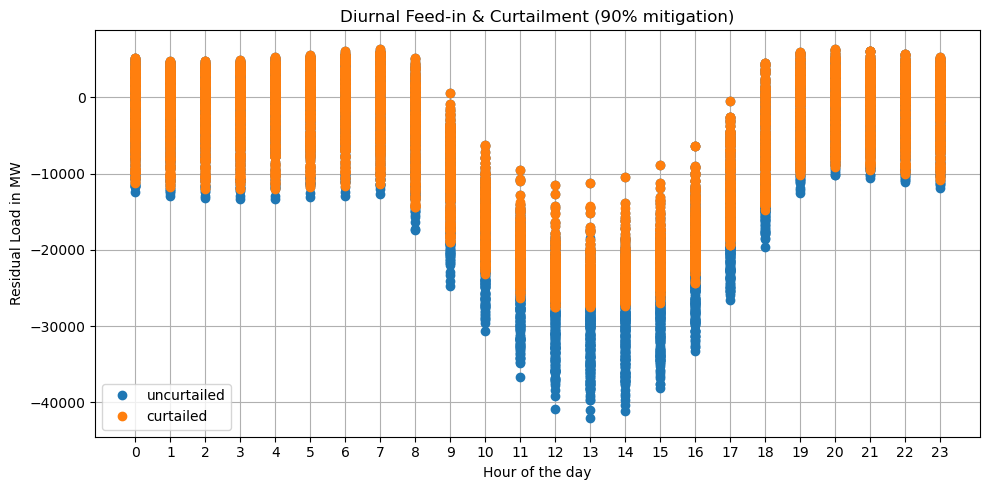

In [424]:
#resampling = "H"
incl_curtailed = True

#xlabel = {"H": "Hours", "D": "Days", "W": "Weeks"}
mitigation = [0.10] #[2.0, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10]

fig = plt.figure(figsize=(10, 5))

# Get and plot the data
for m in mitigation:

    m = str(m) + "0" if m < 1 else str(m) 
    path = "elec_s_10_ec_lc1.0_Co2L" + str(m) + "_1H_2030_0.15_DF_0export.nc"
    n = pypsa.Network(prefix + path)
    
    rlc = calculate_rlc(n, False, False, False)
    average_day = rlc.resample('H').mean()
    rlc_curtail = calculate_rlc(n, False, True, False)
    average_day_curtailed = rlc_curtail.resample('H').mean()
    plt.plot(average_day_curtailed.index.hour, average_day_curtailed, marker='o', linestyle= 'none', label = 'uncurtailed')
    plt.plot(average_day.index.hour, average_day, marker='o', linestyle= 'none', label = 'curtailed')

# Add a title
plt.title("Diurnal Feed-in & Curtailment (90% mitigation)")

# Add axis labels
plt.xlabel('Hour of the day')
plt.ylabel("Residual Load in MW")
#plt.xlim(0, 23)
plt.xticks(range(0, 24))
plt.legend(loc="lower left")
plt.grid()

plt.tight_layout()
plt.savefig(output + "rlc_diurnal_curtdiff" + ".pdf")
plt.show()

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L2.0_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.90_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.80_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.70_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.60_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_1H_2030_0.15_DF_0export.nc has b

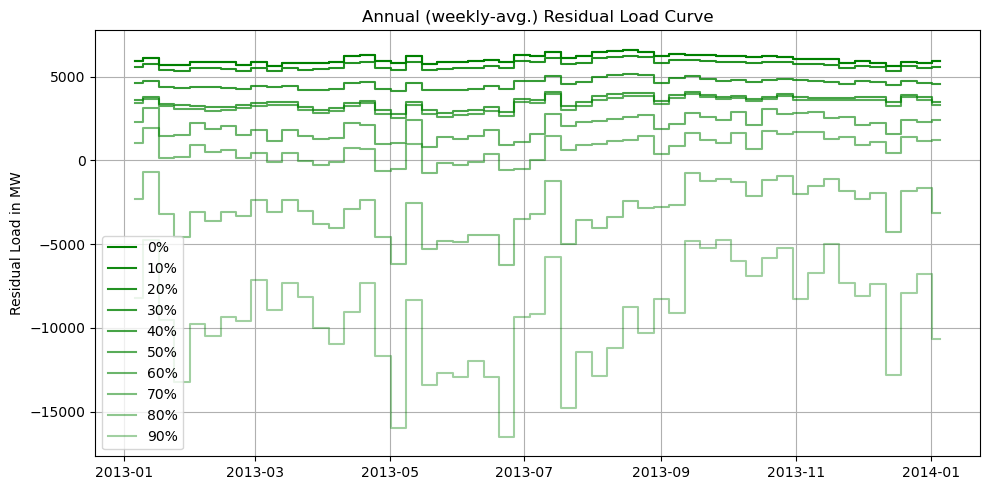

In [419]:
#resampling = "H"
incl_curtailed = True

#xlabel = {"H": "Hours", "D": "Days", "W": "Weeks"}
mitigation = [2.0, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10] #[2.0, 0.50, 0.10]

fig = plt.figure(figsize=(10, 5))

# Get and plot the data
for m in mitigation:

    m = str(m) + "0" if m < 1 else str(m) 
    path = "elec_s_10_ec_lc1.0_Co2L" + str(m) + "_1H_2030_0.15_DF_0export.nc"
    n = pypsa.Network(prefix + path)
    
    rlc = calculate_rlc(n, resample="W", incl_curtailed=incl_curtailed, time_sorted=False)
    plt.step(rlc.index, rlc, where='mid',  label=str(reverse_mitigation(eval(m))) + "%", color="green", alpha=1-reverse_mitigation(eval(m))*0.007)

# Add a title
plt.title("Annual (weekly-avg.) Residual Load Curve")

# Add axis labels
#plt.xlabel('Hour of the day')
plt.ylabel("Residual Load in MW")
#plt.xlim(0, 23)
#plt.xticks(range(0, 24))
plt.legend(loc="lower left")
plt.grid()

plt.tight_layout()
plt.savefig(output + "rlc_annual" + "_inclCurt" + str(incl_curtailed) + ".pdf")
plt.show()

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L2.0_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.90_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.80_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.70_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.60_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_1H_2030_0.15_DF_0export.nc has b

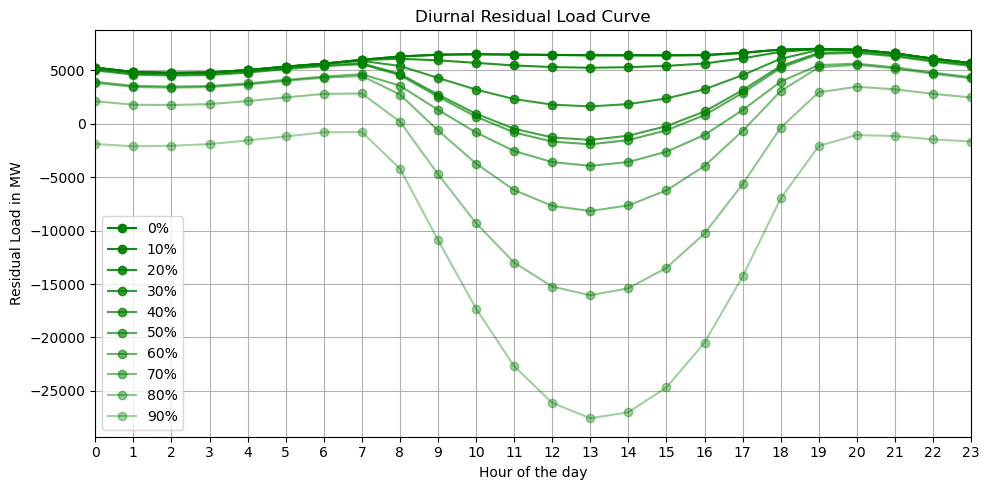

In [420]:
#resampling = "H"
incl_curtailed = True

#xlabel = {"H": "Hours", "D": "Days", "W": "Weeks"}
mitigation = [2.0, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10] #[2.0, 0.50, 0.10]

fig = plt.figure(figsize=(10, 5))

# Get and plot the data
for m in mitigation:

    m = str(m) + "0" if m < 1 else str(m) 
    path = "elec_s_10_ec_lc1.0_Co2L" + str(m) + "_1H_2030_0.15_DF_0export.nc"
    n = pypsa.Network(prefix + path)
    
    rlc = calculate_rlc(n, resample=False, incl_curtailed=incl_curtailed, time_sorted=False)
    average_day = rlc.groupby(rlc.index.hour).mean()
    #rlc.plot(label=str(reverse_mitigation(eval(m))) + "%", color="green", alpha=1-reverse_mitigation(eval(m))*0.007)

    plt.plot(average_day.index, average_day, marker='o', label=str(reverse_mitigation(eval(m))) + "%", color="green", alpha=1-reverse_mitigation(eval(m))*0.007)

# Add a title
plt.title("Diurnal Residual Load Curve")

# Add axis labels
plt.xlabel('Hour of the day')
plt.ylabel("Residual Load in MW")
plt.xlim(0, 23)
plt.xticks(range(0, 24))
plt.legend(loc="lower left")
plt.grid()

plt.tight_layout()
plt.savefig(output + "rlc_diurnal" + "_inclCurt" + str(incl_curtailed) + ".pdf")
plt.show()

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L2.0_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.90_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.80_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.70_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.60_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_1H_2030_0.15_DF_0export.nc has b

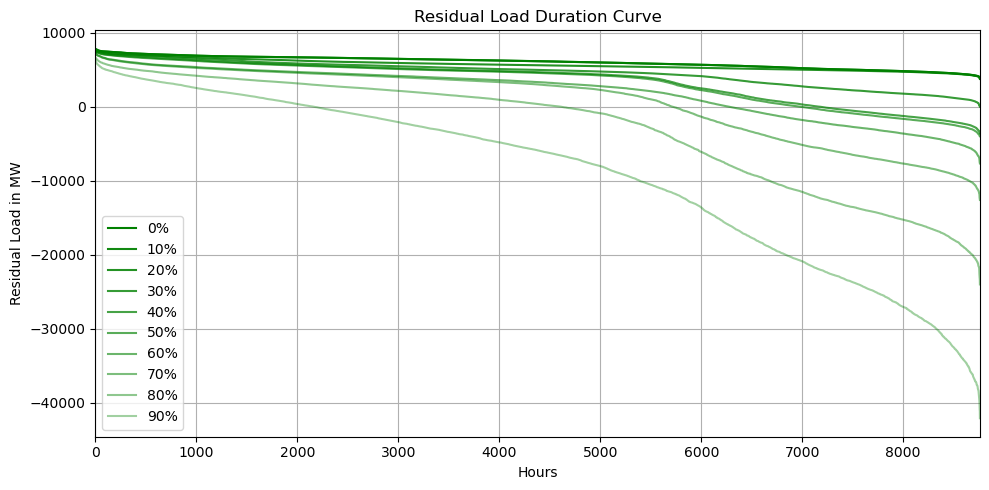

In [421]:
resampling = "H"
incl_curtailed = True

xlabel = {"H": "Hours", "D": "Days", "W": "Weeks"}
mitigation = [2.0, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10]

fig = plt.figure(figsize=(10, 5))

# Get and plot the data
for m in mitigation:

    m = str(m) + "0" if m < 1 else str(m) 
    path = "elec_s_10_ec_lc1.0_Co2L" + str(m) + "_1H_2030_0.15_DF_0export.nc"
    n = pypsa.Network(prefix + path)
    
    rlc = calculate_rlc(n, resample=resampling, incl_curtailed=incl_curtailed, time_sorted=True)
    rlc.plot(label=str(reverse_mitigation(eval(m))) + "%", color="green", alpha=1-reverse_mitigation(eval(m))*0.007)

# Add a title
plt.title("Residual Load Duration Curve")

# Add axis labels
plt.xlabel(xlabel[resampling])
plt.ylabel("Residual Load in MW")
plt.xlim(0, len(rlc))
plt.legend(loc="lower left")
plt.grid()

plt.tight_layout()
plt.savefig(output + "rlc_sorted_" + xlabel[resampling] + "_inclCurt" + str(incl_curtailed) + ".pdf")
plt.show()

In [422]:
# fig = plt.figure(figsize=(30, 5))
# #n.generators_t.p[n.generators[n.generators.carrier == "onwind"].index].sum(axis=1).plot() #.sum() / 1e6 * 3
# wind_power = n.generators.p_nom_opt[n.generators[n.generators.carrier == "onwind"].index]
# wind_profile = n.generators_t.p_max_pu[n.generators[n.generators.carrier == "onwind"].index]
# wind_feed_in = n.generators_t.p[n.generators[n.generators.carrier == "onwind"].index].sum(axis=1)
# (wind_profile * wind_power).sum(axis=1).plot() #.sum() / 1e6 * 3
# wind_feed_in.plot()